# Exploiting Multi Spectral Imagery Information

In [1]:
%%capture
# Install rasterio to handle tif images
!pip install rasterio

In [ ]:
%%capture
# Install CLIP dependencies
!pip install torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import os
import random
from matplotlib import pyplot as plt
from PIL import Image
import rasterio
import pickle
import h5py

from tqdm import tqdm
import torch
import gc

In [3]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Calculating folder size
#! du -sh /content/drive/My\ Drive/<your_path_here>

In [ ]:
def normalize(array):
    ''' Normalization over-image '''
    array = array.astype(np.float32)
    return (array - array.min()) / (array.max() - array.min())


def normalize_per_channel(array):
    ''' Normalization over-channel of a single image '''
    array = array.astype(np.float32)
    for i in range(array.shape[0]):
        band = array[i]
        band_min, band_max = band.min(), band.max()
        if band_max > band_min:
            array[i] = (band - band_min) / (band_max - band_min)
        else:
            array[i] = 0.0 # just in case
    return array

## CLIP

In the notebook, we'll load and freeze OpenAI's CLIP model (only use its image encoder).

In [ ]:
import random
import clip
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device =", device)
# CLIP_model, CLIP_preprocess = clip.load("ViT-B/32", device=device)

device = cpu


## Loading EuroSAT MSI data

In [ ]:
# Unzip EuroSATallBands folder
#!unzip "/content/drive/MyDrive/Thesis CLIP4EO/EuroSATallBands.zip" -d "/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/"

In [8]:
data_path = '/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/'

In [9]:
os.listdir(data_path)

['Pasture',
 'SeaLake',
 'River',
 'AnnualCrop',
 'Residential',
 'PermanentCrop',
 'Industrial',
 'Highway',
 'HerbaceousVegetation',
 'Forest']

In [10]:
total_images = 0
for folder in os.listdir(data_path):
    print(f'Folder "{folder}":', len(os.listdir(data_path + folder)), 'images')
    total_images += len(os.listdir(data_path + folder))

print("\nTotal:", total_images)

Folder "Pasture": 2000 images
Folder "SeaLake": 3000 images
Folder "River": 2500 images
Folder "AnnualCrop": 3000 images
Folder "Residential": 3000 images
Folder "PermanentCrop": 2500 images
Folder "Industrial": 2500 images
Folder "Highway": 2500 images
Folder "HerbaceousVegetation": 3000 images
Folder "Forest": 3000 images

Total: 27000


In [11]:
# Loading and mapping labels
# (in order to correspond to the ones in m-bigearthnet from GEO-Bench)
labels_map = {'SeaLake' : 'Sea or Lake',
              'Pasture': 'Pasture',
              'PermanentCrop': 'Permanent Crop',
              'Residential': 'Residential Buildings',
              'Industrial': 'Industrial Buildings',
              'HerbaceousVegetation': 'Herbaceous Vegetation',
              'Highway': 'Highway',
              'Forest': 'Forest',
              'River': 'River',
              'AnnualCrop': 'Annual Crop'}

# Define labels
labels = list(labels_map.values())

In [12]:
# Build train, validation and test datasets


# TEST dataframe - 5000 images randomly sampled with seed = 42 -----------------
print("\nTEST set: -------------------------------------------------------------")
test_images = []

for image_folder in os.listdir(data_path):
    random.seed(42)
    random_samples = random.sample(os.listdir(data_path + image_folder), 500)
    test_images += random_samples
print(len(test_images), 'images\n')

data = []
for img_id in test_images:
    folder = img_id.split('_')[0]
    filename = os.path.join(data_path, folder, img_id)
    data.append({
        'image_id': img_id,
        'filename': filename,
        'label': labels_map[folder]
    })

test_df = pd.DataFrame(data)
print(test_df.head())


# VALIDATION dataframe - 5000 images randomly sampled with seed = 42 -----------
print("\nVALIDATION set: -------------------------------------------------------")
val_images = []

for image_folder in os.listdir(data_path):
    possible_images = [img for img in os.listdir(data_path + image_folder) if img not in test_images]
    random.seed(42)
    random_samples = random.sample(possible_images, 500)
    val_images += random_samples
print(len(val_images), 'images\n')

data = []
for img_id in val_images:
    folder = img_id.split('_')[0]
    filename = os.path.join(data_path, folder, img_id)
    data.append({
        'image_id': img_id,
        'filename': filename,
        'label': labels_map[folder]
    })

val_df = pd.DataFrame(data)
print(val_df.head())


# TRAIN dataframe - 10000 remaining images randomly sampled with seed = 42 -----
print("\n\nTRAIN set: ----------------------------------------------------------")
train_images = []

for image_folder in os.listdir(data_path):
    possible_images = [img for img in os.listdir(data_path + image_folder) if (img not in test_images and img not in val_images)]
    random.seed(42)
    random_samples = random.sample(possible_images, 1000)
    train_images += random_samples
print(len(train_images), 'images\n')

data = []
for img_id in train_images:
    folder = img_id.split('_')[0]
    filename = os.path.join(data_path, folder, img_id)
    data.append({
        'image_id': img_id,
        'filename': filename,
        'label': labels_map[folder]
    })

train_df = pd.DataFrame(data)
print(train_df.head())


TEST set: -------------------------------------------------------------
5000 images

           image_id                                           filename  \
0   Pasture_314.tif  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   
1  Pasture_1239.tif  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   
2  Pasture_1065.tif  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   
3   Pasture_524.tif  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   
4  Pasture_1571.tif  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   

     label  
0  Pasture  
1  Pasture  
2  Pasture  
3  Pasture  
4  Pasture  

VALIDATION set: -------------------------------------------------------
5000 images

           image_id                                           filename  \
0   Pasture_755.tif  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   
1  Pasture_1328.tif  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   
2  Pasture_1079.tif  /content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...   
3  Pastur

In [13]:
#set(test_df.image_id).intersection(set(train_df))
set(test_df.image_id) & set(val_df.image_id) & set(train_df.image_id)

set()

In [11]:
test_df.label.value_counts()

,count
label,
Pasture,500
Sea or Lake,500
River,500
Annual Crop,500
Residential Buildings,500
Permanent Crop,500
Industrial Buildings,500
Highway,500
Herbaceous Vegetation,500


In [12]:
val_df.label.value_counts()

,count
label,
Pasture,500
Sea or Lake,500
River,500
Annual Crop,500
Residential Buildings,500
Permanent Crop,500
Industrial Buildings,500
Highway,500
Herbaceous Vegetation,500


In [13]:
train_df.label.value_counts()

,count
label,
Pasture,1000
Sea or Lake,1000
River,1000
Annual Crop,1000
Residential Buildings,1000
Permanent Crop,1000
Industrial Buildings,1000
Highway,1000
Herbaceous Vegetation,1000


In [ ]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Sample path
sample_tif_path = "/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/River/River_650.tif"

with rasterio.open(sample_tif_path) as src:
    print('Source type: ', type(src))
    print("Metadata keys:")
    print(src.meta)
    print()
    img = src.read()  # shape: (13, H, W)
    print(f"Image type: {type(img)}")
    print(f"Image shape: {img.shape}")  # Should be (13, H, W)
    print(f"Image data type: {img.dtype}")
    print("Location metadata:")
    print(f"- CRS: {src.crs}")
    print(f"- Transform:\n{src.transform}")

Source type:  <class 'rasterio.io.DatasetReader'>
Metadata keys:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 64, 'height': 64, 'count': 13, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]]'), 'transform': Affine(10.00255781559539, 0.0, 320134.7934680959,
       0.0, -9.994221518072019, 5509823.11151)}

Image type: <class 'numpy.ndarray'>
Image shape: (13, 64, 64)
Image data type: uint16
Location metadata:
- 

> - **CRS(CRS stands for Coordinate Reference System)**: defines how the pixel coordinates of your image relate to real-world locations on the Earth's surface. It's useful to map images accurately on the Earth and align datasets from different sources.
- **Transform**: is an affine transform matrix that maps pixel indices (row, col) to spatial coordinates (x, y). It helps determine Where each pixel is located in the real world.

> **EuroSAT MSI bands:**

>  | Index | Band Number | Name            | Wavelength (nm) | Resolution |
  |-------|-------------|------------------|------------------|------------|
  | 0     | B1          | Coastal aerosol  | 443              | 60m        |
  | 1     | B2          | Blue             | 490              | 10m        |
  | 2     | B3          | Green            | 560              | 10m        |
  | 3     | B4          | Red              | 665              | 10m        |
  | 4     | B5          | Red Edge 1       | 705              | 20m        |
  | 5     | B6          | Red Edge 2       | 740              | 20m        |
  | 6     | B7          | Red Edge 3       | 783              | 20m        |
  | 7     | B8          | NIR              | 842              | 10m        |
  | 8     | B8A         | Narrow NIR       | 865              | 20m        |
  | 9     | B9          | Water vapor      | 945              | 60m        |
  | 10    | B10         | SWIR - Cirrus    | 1375             | 60m        |
  | 11    | B11         | SWIR 1           | 1610             | 20m        |
  | 12    | B12         | SWIR 2           | 2190             | 20m        |



 River_224.tif 



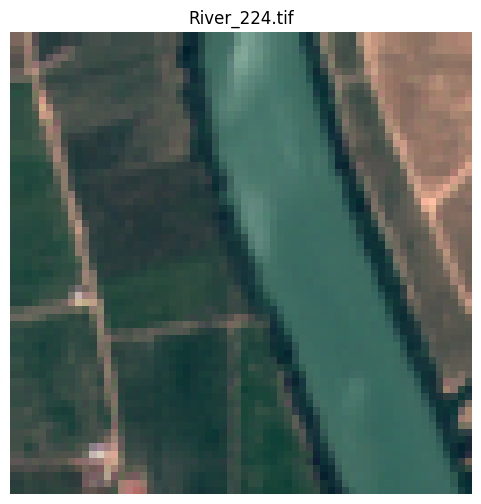

In [ ]:
# Normalize and plot RGB composite
def normalize(array):
    array = array.astype(np.float32)
    return (array - array.min()) / (array.max() - array.min())

image = train_df.iloc[2505]

with rasterio.open(image.filename) as src:
    img = src.read()

rgb = np.stack([img[3], img[2], img[1]])  # Bands 4, 3, 2 == R, G, B -> shape (3, 64, 64)
rgb_norm = normalize(rgb) # all pixel values in [0, 1]

print('\n', image.image_id, '\n')
plt.figure(figsize = (6, 6))
plt.imshow(np.transpose((rgb_norm * 255).astype(np.uint8), (1, 2, 0)))  # switch dimensions (C, H, W) -> (H, W, C) (invalid shape otherwise)

# NOTICE: for visualization purposes, even just doing:
#plt.imshow(np.transpose(rgb_norm, (1, 2, 0)))
# would have worked, as imshow expects an image either in the float [0...1] format
# or in the integer [0...255] format (which needs casting to np.uint8).
# So the simple normalized image would have been enough.
# However, this type isn't accepted by the CLIP image preprocessing, so the
# conversion into [0...255] + uint8 cast is necessary.

plt.title(image.image_id)
plt.axis('off')
plt.show()

In [ ]:
# Test CLIP on this sample image and the given labels

# Preprocess
image_input = CLIP_preprocess(Image.fromarray(np.transpose((rgb_norm * 255).astype(np.uint8), (1, 2, 0)))).unsqueeze(0).to(device)
text_input = clip.tokenize(['a satellite image of ' + l.lower() for l in labels]).to(device)

# Calculate features
with torch.no_grad():
    image_features = CLIP_model.encode_image(image_input)
    text_features = CLIP_model.encode_text(text_input)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

similarity = image_features @ text_features.T # normalized dot product -> cosine similarity
softmax = (100.0 * image_features @ text_features.T).softmax(dim=-1)
sigmoid = (image_features @ text_features.T).sigmoid()

values, indices = softmax[0].topk(10)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

     Annual Crop: 38.17%
  Permanent Crop: 37.27%
         Pasture: 8.59%
           River: 8.55%
Industrial Buildings: 2.24%
         Highway: 2.02%
     Sea or Lake: 1.19%
Herbaceous Vegetation: 0.89%
Residential Buildings: 0.71%
          Forest: 0.35%


### $\bullet$ Normalize per-channel over image


 River_224.tif 



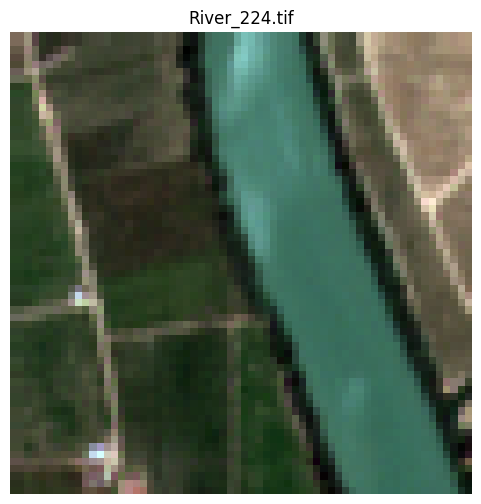


Top predictions:

  Permanent Crop: 33.29%
     Annual Crop: 32.92%
           River: 12.26%
         Pasture: 9.48%
Industrial Buildings: 5.39%
         Highway: 2.70%
     Sea or Lake: 1.51%
Residential Buildings: 1.35%
Herbaceous Vegetation: 0.82%
          Forest: 0.28%


In [ ]:
# Try with a different normalization (per bands)

def normalize_per_channel(array):
    array = array.astype(np.float32)
    for i in range(array.shape[0]):
        band = array[i]
        band_min, band_max = band.min(), band.max()
        if band_max > band_min:
            array[i] = (band - band_min) / (band_max - band_min)
        else:
            array[i] = 0.0 # just in case
    return array


rgb_norm_bands = normalize_per_channel(rgb) # all pixel values in [0, 1] but per bands

print('\n', image.image_id, '\n')
plt.figure(figsize = (6, 6))
plt.imshow(np.transpose((rgb_norm_bands * 255).astype(np.uint8), (1, 2, 0)))
plt.title(image.image_id)
plt.axis('off')
plt.show()


# Preprocess
image_input = CLIP_preprocess(Image.fromarray(np.transpose((rgb_norm_bands * 255).astype(np.uint8), (1, 2, 0)))).unsqueeze(0).to(device)
text_input = clip.tokenize(['a satellite image of ' + l.lower() for l in labels]).to(device)

# Calculate features
with torch.no_grad():
    image_features = CLIP_model.encode_image(image_input)
    text_features = CLIP_model.encode_text(text_input)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

similarity = image_features @ text_features.T # normalized dot product -> cosine similarity
softmax = (100.0 * image_features @ text_features.T).softmax(dim=-1)
sigmoid = (image_features @ text_features.T).sigmoid()

values, indices = softmax[0].topk(10)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")

In [ ]:
# Careful: using a different library to load the images, the
# shape changes and code needs to be adjusted accordingly
import tifffile

image = train_df.iloc[2505]
print(image.image_id)

img_tifff = tifffile.imread(image.filename)
print(type(img_tifff), img_tifff.shape)

with rasterio.open(image.filename) as src:
    img_rasterio = src.read()

print(type(img_rasterio), img_rasterio.shape)

River_224.tif
<class 'numpy.ndarray'> (64, 64, 13)
<class 'numpy.ndarray'> (13, 64, 64)


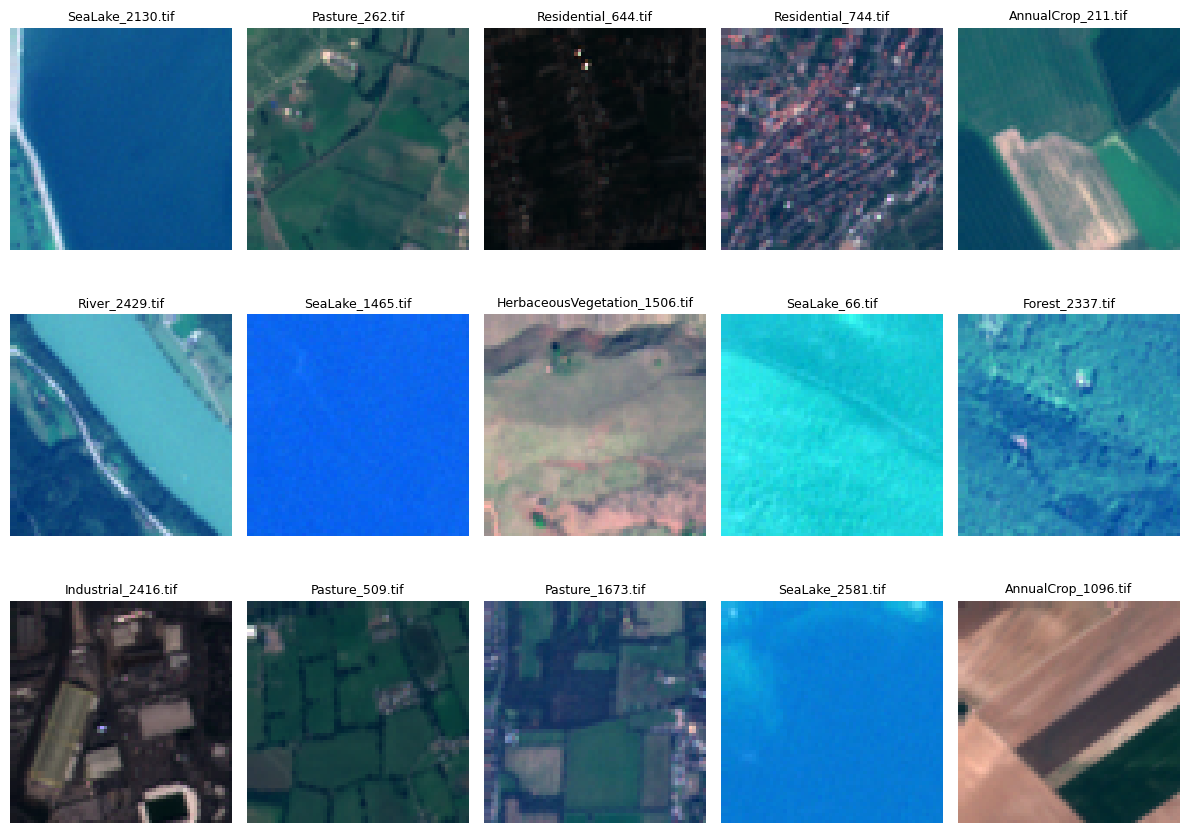

In [ ]:
# Plot a sample images from the test dataframe
import rasterio

cols = 5
rows = 3

random.seed(42)
sample = random.sample(train_df.filename.tolist(), rows * cols)

fig, axes = plt.subplots(rows, cols, figsize = (12, rows * 3))
axes = axes.flatten()

for i, image_path in enumerate(sample):

    with rasterio.open(image_path) as src:
        img = src.read()

    rgb = np.stack([img[3], img[2], img[1]]) # bands 4, 3, 2 (R, G, B)
    rgb_norm = normalize(rgb)
    axes[i].imshow(np.transpose(rgb_norm, (1, 2, 0))) # switch dimensions (C, H, W) -> (H, W, C)
    axes[i].set_title(image_path.split('/')[-1], fontsize = 9)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

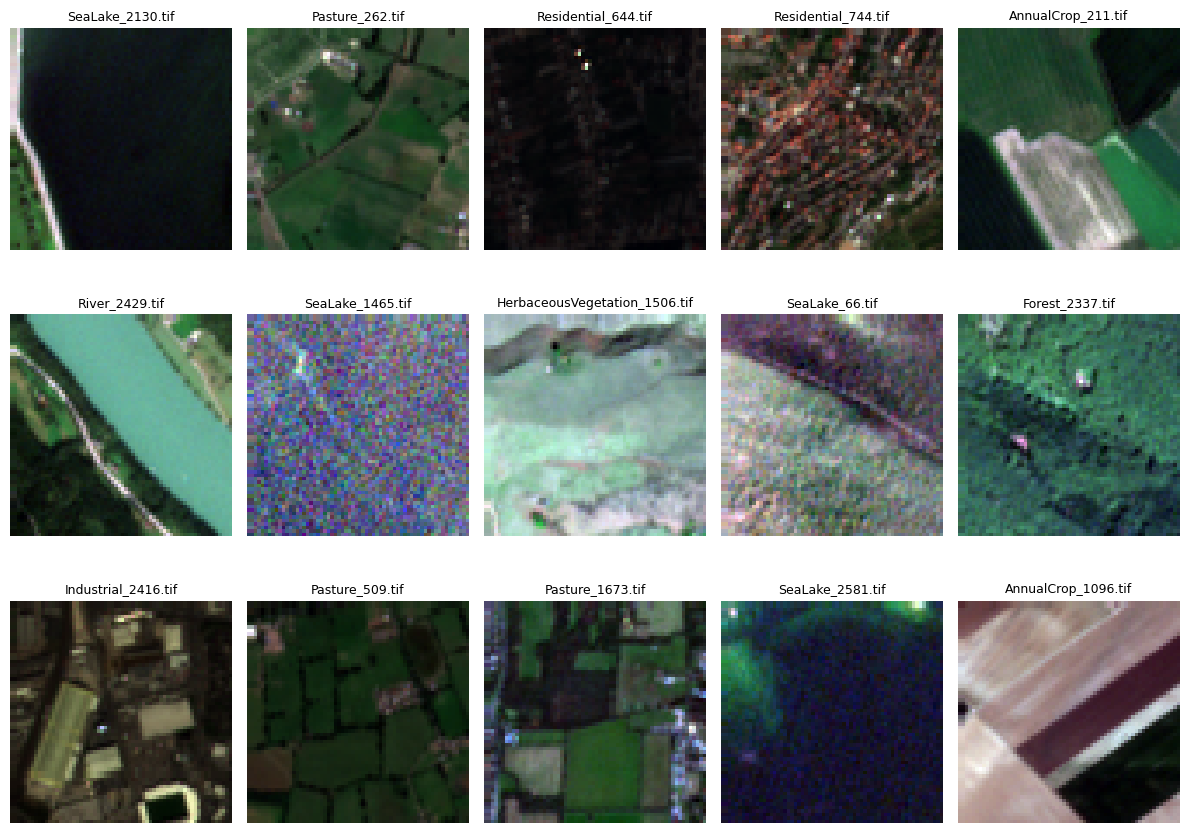

In [ ]:
# Visualize sample images with different normalization
cols = 5
rows = 3

random.seed(42)
sample = random.sample(train_df.filename.tolist(), rows * cols)

fig, axes = plt.subplots(rows, cols, figsize = (12, rows * 3))
axes = axes.flatten()

for i, image_path in enumerate(sample):

    with rasterio.open(image_path) as src:
        img = src.read()

    rgb = np.stack([img[3], img[2], img[1]]) # bands 4, 3, 2 (R, G, B)
    rgb_norm_bands = normalize_per_channel(rgb)
    axes[i].imshow(np.transpose(rgb_norm_bands, (1, 2, 0))) # switch dimensions (C, H, W) -> (H, W, C)
    axes[i].set_title(image_path.split('/')[-1], fontsize = 9)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
os.listdir(data_path)

['Pasture',
 'SeaLake',
 'River',
 'AnnualCrop',
 'Residential',
 'PermanentCrop',
 'Industrial',
 'Highway',
 'HerbaceousVegetation',
 'Forest']


 SeaLake_64.tif 



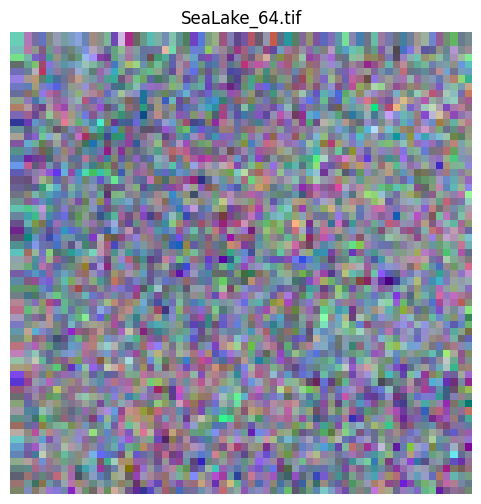


Top predictions:

         Highway: 39.07%
          Forest: 22.05%
     Annual Crop: 12.07%
         Pasture: 7.90%
  Permanent Crop: 7.40%
Herbaceous Vegetation: 3.17%
Industrial Buildings: 2.58%
Residential Buildings: 2.09%
     Sea or Lake: 2.03%
           River: 1.63%


In [ ]:
image_id = 'SeaLake_64.tif'

with rasterio.open(os.path.join(data_path, 'SeaLake', image_id)) as src:
    img = src.read()

rgb = np.stack([img[3], img[2], img[1]])  # Bands 4, 3, 2 == R, G, B -> shape (3, 64, 64)
rgb_norm_bands = normalize_per_channel(rgb) # all pixel values in [0, 1]

print('\n', image_id, '\n')
plt.figure(figsize = (6, 6))
plt.imshow(np.transpose((rgb_norm_bands * 255).astype(np.uint8), (1, 2, 0)))  # switch dimensions (C, H, W) -> (H, W, C) (invalid shape otherwise)

plt.title(image_id)
plt.axis('off')
plt.show()


# Preprocess
image_input = CLIP_preprocess(Image.fromarray(np.transpose((rgb_norm_bands * 255).astype(np.uint8), (1, 2, 0)))).unsqueeze(0).to(device)
text_input = clip.tokenize(['a satellite image of ' + l.lower() for l in labels]).to(device)

# Calculate features
with torch.no_grad():
    image_features = CLIP_model.encode_image(image_input)
    text_features = CLIP_model.encode_text(text_input)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

similarity = image_features @ text_features.T # normalized dot product -> cosine similarity
softmax = (100.0 * image_features @ text_features.T).softmax(dim=-1)
sigmoid = (image_features @ text_features.T).sigmoid()

values, indices = softmax[0].topk(10)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")

$\to$ This normalization is not good on RGB

### $\bullet$ Normalize per-channel over dataset (min/max)

In [ ]:
sample_img = test_df.iloc[0]
print(sample_img.image_id)

with rasterio.open(sample_img.filename) as src:
    img_data = src.read()

Pasture_314.tif


In [ ]:
img_data.shape

(13, 64, 64)

In [ ]:
img_data[0]

array([[1167, 1167, 1172, ..., 1190, 1190, 1190],
       [1167, 1167, 1172, ..., 1190, 1190, 1190],
       [1165, 1165, 1170, ..., 1190, 1191, 1191],
       ...,
       [1205, 1205, 1209, ..., 1177, 1174, 1172],
       [1210, 1210, 1215, ..., 1179, 1176, 1174],
       [1214, 1214, 1220, ..., 1180, 1178, 1175]], dtype=uint16)

In [ ]:
# Define proxy dataframes containing the image pixel values
def load_images(input_df):
    df = input_df.copy()
    image_arrays = []
    for path in tqdm(df['filename']):
        with rasterio.open(path) as src:
            img = src.read()  # shape: (13, 64, 64)
        image_arrays.append(img)
    df['image_arrays'] = image_arrays
    return df

train_df_proxy = load_images(train_df)
val_df_proxy = load_images(val_df)
test_df_proxy = load_images(test_df)

100%|██████████| 5000/5000 [11:27<00:00,  7.28it/s]


> **Note**: the `.csv` format doesn't work well to save numpy arrays, as it converts them to strings and they need to be parsed properly when loading from file. Instead, use `pickle` as the `.pkl` format allows to preserve data and shape.

In [ ]:
# Save to files with numpy arrays in their native form
train_df_proxy.to_pickle('/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/train_df_proxy.pkl')
val_df_proxy.to_pickle('/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/val_df_proxy.pkl')
test_df_proxy.to_pickle('/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/test_df_proxy.pkl')

In [ ]:
train_df_proxy.head()

,image_id,filename,label,image_arrays
0,Pasture_306.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1074, 1074, 1073, 1072, 1072, 1071, 1070, 1..."
1,Pasture_1255.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1176, 1176, 1175, 1175, 1175, 1175, 1176, 1..."
2,Pasture_1058.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1175, 1175, 1176, 1177, 1179, 1180, 1182, 1..."
3,Pasture_505.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1150, 1150, 1149, 1149, 1149, 1149, 1149, 1..."
4,Pasture_1607.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1127, 1127, 1128, 1128, 1129, 1129, 1130, 1..."


In [ ]:
train_df_proxy.iloc[0].image_arrays.shape

(13, 64, 64)

In [ ]:
# Read from file
train_df_proxy = pd.read_pickle("/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/train_df_proxy.pkl")
val_df_proxy = pd.read_pickle("/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/val_df_proxy.pkl")
test_df_proxy = pd.read_pickle("/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/test_df_proxy.pkl")

In [ ]:
train_df_proxy

,image_id,filename,label,image_arrays
0,Pasture_306.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1074, 1074, 1073, 1072, 1072, 1071, 1070, 1..."
1,Pasture_1255.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1176, 1176, 1175, 1175, 1175, 1175, 1176, 1..."
2,Pasture_1058.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1175, 1175, 1176, 1177, 1179, 1180, 1182, 1..."
3,Pasture_505.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1150, 1150, 1149, 1149, 1149, 1149, 1149, 1..."
4,Pasture_1607.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1127, 1127, 1128, 1128, 1129, 1129, 1130, 1..."
...,...,...,...,...
9995,Forest_2233.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Forest,"[[[1042, 1042, 1043, 1042, 1042, 1041, 1039, 1..."
9996,Forest_1437.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Forest,"[[[1106, 1106, 1105, 1105, 1104, 1104, 1104, 1..."
9997,Forest_2423.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Forest,"[[[965, 965, 965, 966, 966, 967, 967, 968, 968..."
9998,Forest_1306.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Forest,"[[[1177, 1177, 1177, 1178, 1179, 1179, 1180, 1..."


In [ ]:
train_df_proxy.shape, val_df_proxy.shape, test_df_proxy.shape

((10000, 4), (5000, 4), (5000, 4))

In [ ]:
train_df_proxy.iloc[0].image_arrays.shape

(13, 64, 64)

In [ ]:
train_df_proxy.iloc[0].image_arrays.reshape(13, -1).shape # should be (13, 4096)

(13, 4096)

In [ ]:
train_df_proxy.iloc[0].image_arrays.reshape(13, -1).min(axis = 1)
# train_df_proxy.iloc[0].image_arrays.reshape(13, -1).min(axis = 0)
# train_df_proxy.iloc[0].image_arrays.reshape(13, -1).min()

array([ 998,  715,  612,  380,  852, 1765, 2046, 1752,  839,    8, 1321,
        542, 2321], dtype=uint16)

In [ ]:
def compute_channel_min_max(df):
    channel_mins = np.full(13, np.inf)
    channel_maxs = np.full(13, -np.inf)

    for img in tqdm(df['image_arrays']):
        channel_mins = np.minimum(channel_mins, img.reshape(13, -1).min(axis=1))
        channel_maxs = np.maximum(channel_maxs, img.reshape(13, -1).max(axis=1))

    return channel_mins, channel_maxs

train_mins, train_maxs = compute_channel_min_max(train_df_proxy)
val_mins, val_maxs = compute_channel_min_max(val_df_proxy)
test_mins, test_maxs = compute_channel_min_max(test_df_proxy)

100%|██████████| 5000/5000 [00:00<00:00, 6880.47it/s]


In [ ]:
def normalize_images(df, channel_mins, channel_maxs):
    df = df.copy()
    normalized_images = []

    for img in tqdm(df['image_arrays']):
        img_norm = (img - channel_mins[:, None, None]) / (channel_maxs[:, None, None] - channel_mins[:, None, None] + 1e-8)
        img_norm2 = np.clip(img_norm, 0, 1)  # handle possible problems
        # Conta quante volte clippa per vedere l'impatto di questa cosa
        change_pixel = np.sum(np.where(img_norm != img_norm2)) ###
        normalized_images.append(img_norm.astype(np.float32))

    df['image_norm'] = normalized_images
    return df, change_pixel ###

# Apply to train/val/test using train stats
train_df_proxy_norm = normalize_images(train_df_proxy, train_mins, 0.5 * train_maxs)
val_df_proxy_norm = normalize_images(val_df_proxy, val_mins, 0.5 * val_maxs)
test_df_proxy_norm = normalize_images(test_df_proxy, test_mins, 0.5 * test_maxs)

100%|██████████| 5000/5000 [00:03<00:00, 1565.27it/s]


In [ ]:
train_df_proxy_norm.head()

,image_id,filename,label,image_arrays,image_norm
0,Pasture_306.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1074, 1074, 1073, 1072, 1072, 1071, 1070, 1...","[[[0.014621441, 0.014621441, 0.0145622445, 0.0..."
1,Pasture_1255.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1176, 1176, 1175, 1175, 1175, 1175, 1176, 1...","[[[0.020659445, 0.020659445, 0.020600248, 0.02..."
2,Pasture_1058.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1175, 1175, 1176, 1177, 1179, 1180, 1182, 1...","[[[0.020600248, 0.020600248, 0.020659445, 0.02..."
3,Pasture_505.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1150, 1150, 1149, 1149, 1149, 1149, 1149, 1...","[[[0.019120345, 0.019120345, 0.01906115, 0.019..."
4,Pasture_1607.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1127, 1127, 1128, 1128, 1129, 1129, 1130, 1...","[[[0.017758835, 0.017758835, 0.017818032, 0.01..."


In [ ]:
del train_df_proxy, val_df_proxy, test_df_proxy

In [ ]:
# Save to file
train_df_proxy_norm.to_pickle('/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/train_df_proxy_norm.pkl')
val_df_proxy_norm.to_pickle('/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/val_df_proxy_norm.pkl')
test_df_proxy_norm.to_pickle('/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/test_df_proxy_norm.pkl')

In [ ]:
# Load from file
train_df_proxy_norm = pd.read_pickle("/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/train_df_proxy_norm.pkl")
val_df_proxy_norm = pd.read_pickle("/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/val_df_proxy_norm.pkl")
test_df_proxy_norm = pd.read_pickle("/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/test_df_proxy_norm.pkl")

In [ ]:
train_df_proxy_norm

,image_id,filename,label,image_arrays,image_norm
0,Pasture_306.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1074, 1074, 1073, 1072, 1072, 1071, 1070, 1...","[[[0.014621441, 0.014621441, 0.0145622445, 0.0..."
1,Pasture_1255.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1176, 1176, 1175, 1175, 1175, 1175, 1176, 1...","[[[0.020659445, 0.020659445, 0.020600248, 0.02..."
2,Pasture_1058.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1175, 1175, 1176, 1177, 1179, 1180, 1182, 1...","[[[0.020600248, 0.020600248, 0.020659445, 0.02..."
3,Pasture_505.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1150, 1150, 1149, 1149, 1149, 1149, 1149, 1...","[[[0.019120345, 0.019120345, 0.01906115, 0.019..."
4,Pasture_1607.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1127, 1127, 1128, 1128, 1129, 1129, 1130, 1...","[[[0.017758835, 0.017758835, 0.017818032, 0.01..."
...,...,...,...,...,...
9995,Forest_2233.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Forest,"[[[1042, 1042, 1043, 1042, 1042, 1041, 1039, 1...","[[[0.012727165, 0.012727165, 0.012786361, 0.01..."
9996,Forest_1437.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Forest,"[[[1106, 1106, 1105, 1105, 1104, 1104, 1104, 1...","[[[0.016515717, 0.016515717, 0.01645652, 0.016..."
9997,Forest_2423.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Forest,"[[[965, 965, 965, 966, 966, 967, 967, 968, 968...","[[[0.008169064, 0.008169064, 0.008169064, 0.00..."
9998,Forest_1306.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Forest,"[[[1177, 1177, 1177, 1178, 1179, 1179, 1180, 1...","[[[0.020718642, 0.020718642, 0.020718642, 0.02..."


In [ ]:
train_df_proxy_norm.columns

Index(['image_id', 'filename', 'label', 'image_arrays', 'image_norm'], dtype='object')

Visualize per-channel pixel distribution before and after normalization (can't plot overlapping histograms, plot separately)

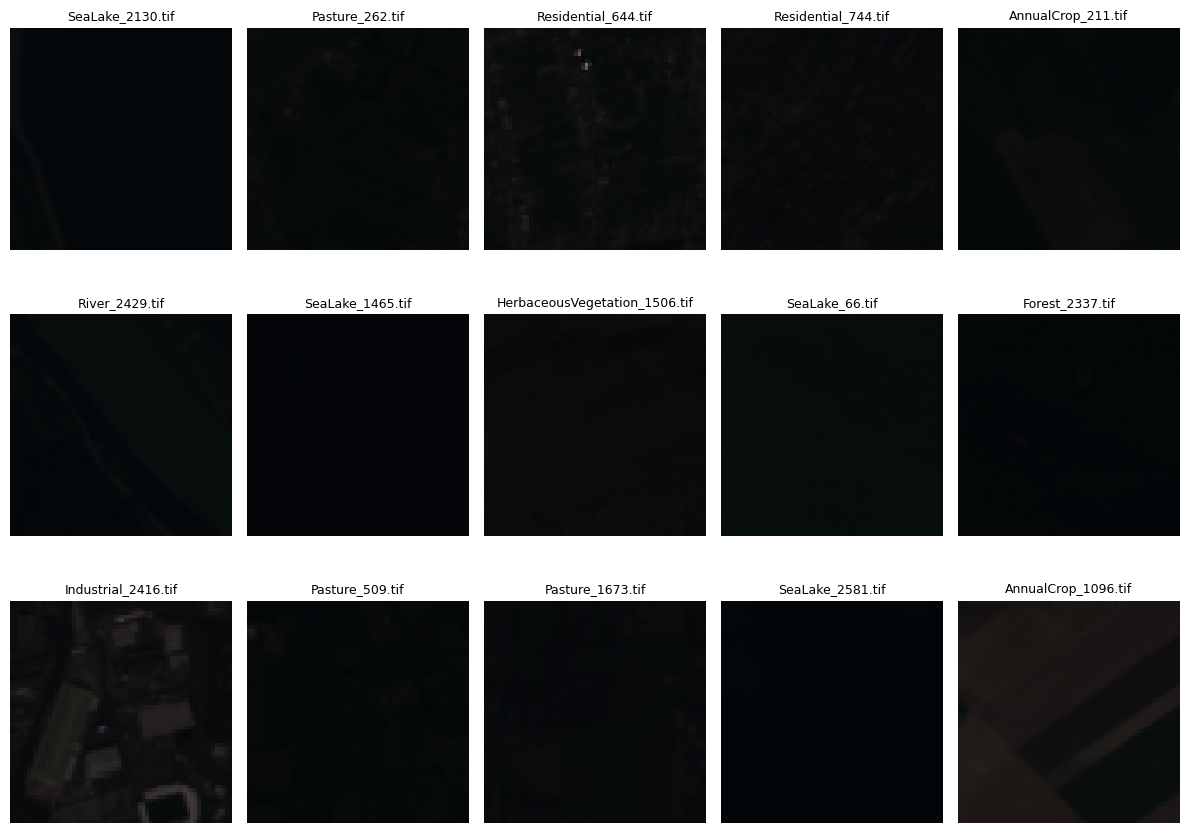

In [ ]:
# Plot a sample images from the test dataframe
import rasterio

cols = 5
rows = 3

random.seed(42)
sample = random.sample(train_df_proxy_norm.filename.tolist(), rows * cols)

fig, axes = plt.subplots(rows, cols, figsize = (12, rows * 3))
axes = axes.flatten()

for i, image_path in enumerate(sample):

    img = train_df_proxy_norm[train_df_proxy_norm.image_id == image_path.split('/')[-1]].image_norm.item()

    rgb = np.stack([img[3], img[2], img[1]]) # bands 4, 3, 2 (R, G, B)
    axes[i].imshow(np.transpose(rgb, (1, 2, 0))) # switch dimensions (C, H, W) -> (H, W, C)
    axes[i].set_title(image_path.split('/')[-1], fontsize = 9)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
train_df_proxy_norm

,image_id,filename,label,image_arrays,image_norm
0,Pasture_306.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1074, 1074, 1073, 1072, 1072, 1071, 1070, 1...","[[[0.014621441, 0.014621441, 0.0145622445, 0.0..."
1,Pasture_1255.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1176, 1176, 1175, 1175, 1175, 1175, 1176, 1...","[[[0.020659445, 0.020659445, 0.020600248, 0.02..."
2,Pasture_1058.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1175, 1175, 1176, 1177, 1179, 1180, 1182, 1...","[[[0.020600248, 0.020600248, 0.020659445, 0.02..."
3,Pasture_505.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1150, 1150, 1149, 1149, 1149, 1149, 1149, 1...","[[[0.019120345, 0.019120345, 0.01906115, 0.019..."
4,Pasture_1607.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Pasture,"[[[1127, 1127, 1128, 1128, 1129, 1129, 1130, 1...","[[[0.017758835, 0.017758835, 0.017818032, 0.01..."
...,...,...,...,...,...
9995,Forest_2233.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Forest,"[[[1042, 1042, 1043, 1042, 1042, 1041, 1039, 1...","[[[0.012727165, 0.012727165, 0.012786361, 0.01..."
9996,Forest_1437.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Forest,"[[[1106, 1106, 1105, 1105, 1104, 1104, 1104, 1...","[[[0.016515717, 0.016515717, 0.01645652, 0.016..."
9997,Forest_2423.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Forest,"[[[965, 965, 965, 966, 966, 967, 967, 968, 968...","[[[0.008169064, 0.008169064, 0.008169064, 0.00..."
9998,Forest_1306.tif,/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT ...,Forest,"[[[1177, 1177, 1177, 1178, 1179, 1179, 1180, 1...","[[[0.020718642, 0.020718642, 0.020718642, 0.02..."


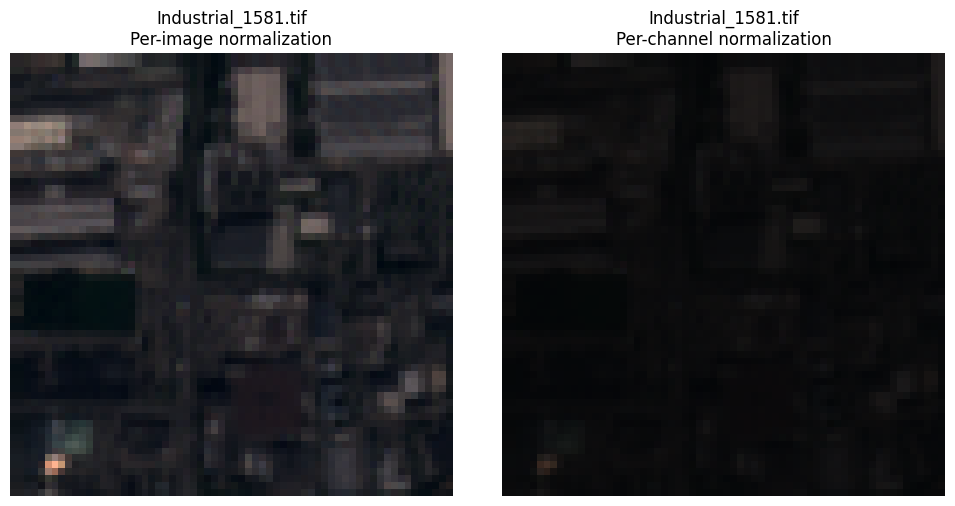

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def normalize_per_image(img):
    # Normalize globally across all pixels and channels of a single image
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min + 1e-8)

def plot_rgb_image(img, title="", ax=None):
    rgb = img[[3, 2, 1], :, :]  # B4 (Red), B3 (Green), B2 (Blue)
    rgb = normalize_per_image(rgb)  # Normalize globally for visualization
    rgb = np.transpose(rgb, (1, 2, 0))  # (H, W, C)
    ax.imshow(rgb)
    ax.set_title(title)
    ax.axis('off')

def plot_norm_rgb_image(norm_img, title="", ax=None):
    rgb = norm_img[[3, 2, 1], :, :]  # B4, B3, B2
    rgb = np.transpose(rgb, (1, 2, 0))  # (H, W, C)
    ax.imshow(rgb)
    ax.set_title(title)
    ax.axis('off')


#sample = train_df.iloc[2505]
sample_msi = train_df_proxy_norm.iloc[6002]

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

# Left: original image (per-image normalized for display only)
plot_rgb_image(sample_msi['image_arrays'], title=f"{sample_msi['image_id']}\nPer-image normalization", ax=axes[0])
# Right: dataset-normalized image (already in [0, 1])
plot_norm_rgb_image(sample_msi['image_norm'], title=f"{sample_msi['image_id']}\nPer-channel normalization", ax=axes[1])

plt.tight_layout()
plt.show()


At least looking at the RGB, the pixel values seem a bit flat...

In [ ]:
rgb_bands = sample_msi['image_norm'][[3, 2, 1], :, :]
rgb_bands

array([[[0.05339476, 0.05339476, 0.05557342, ..., 0.05725205,
         0.11028966, 0.12464731],
        [0.05339476, 0.05339476, 0.05557342, ..., 0.05725205,
         0.11028966, 0.12464731],
        [0.04860888, 0.04860888, 0.04693025, ..., 0.06060931,
         0.11403979, 0.1262188 ],
        ...,
        [0.03814422, 0.03814422, 0.03185828, ..., 0.02835816,
         0.02439373, 0.03589414],
        [0.04185864, 0.04185864, 0.03867995, ..., 0.02175078,
         0.03860852, 0.04782313],
        [0.04660881, 0.04660881, 0.04596593, ..., 0.03117969,
         0.03414408, 0.03160827]],

       [[0.05128755, 0.05128755, 0.05368049, ..., 0.05403765,
         0.10186078, 0.11296832],
        [0.05128755, 0.05128755, 0.05368049, ..., 0.05403765,
         0.10186078, 0.11296832],
        [0.05200186, 0.05200186, 0.04446587, ..., 0.05950212,
         0.10539662, 0.11257545],
        ...,
        [0.04035858, 0.04035858, 0.03707275, ..., 0.03278688,
         0.03025108, 0.03535841],
        [0.0

In [ ]:
rgb_bands.shape

(3, 64, 64)


Original image: -------------------------------------------------------



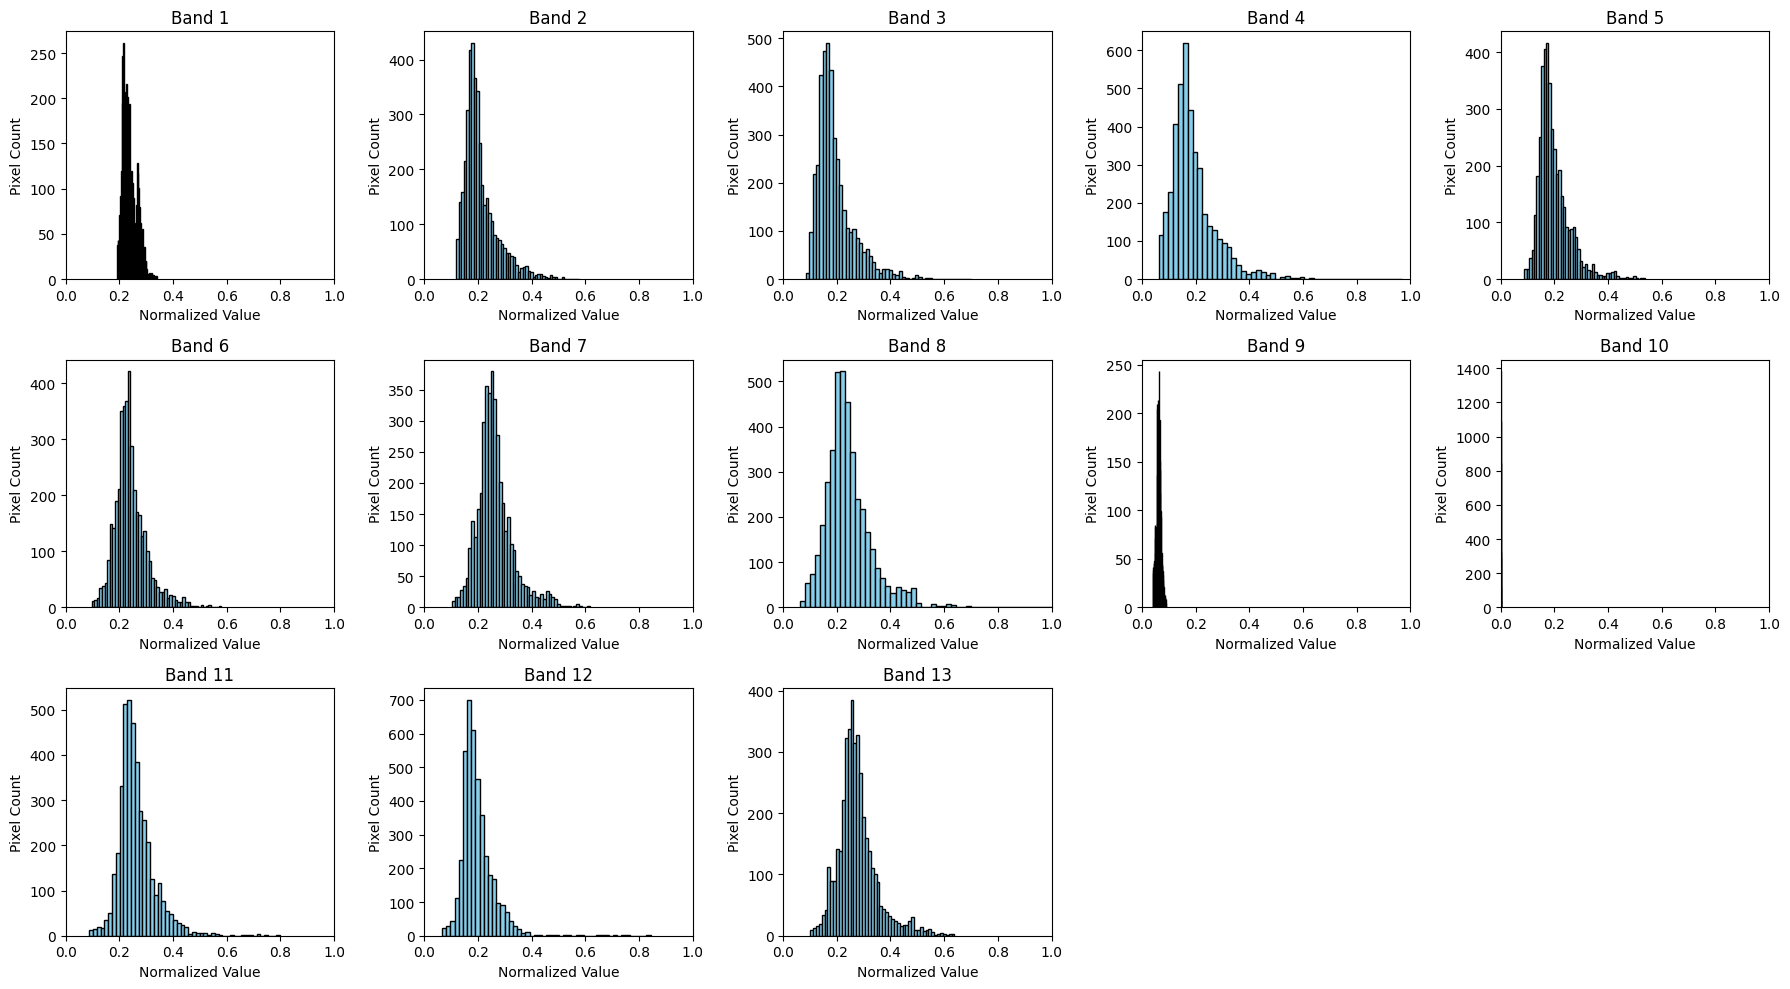


Normalized image: -----------------------------------------------------



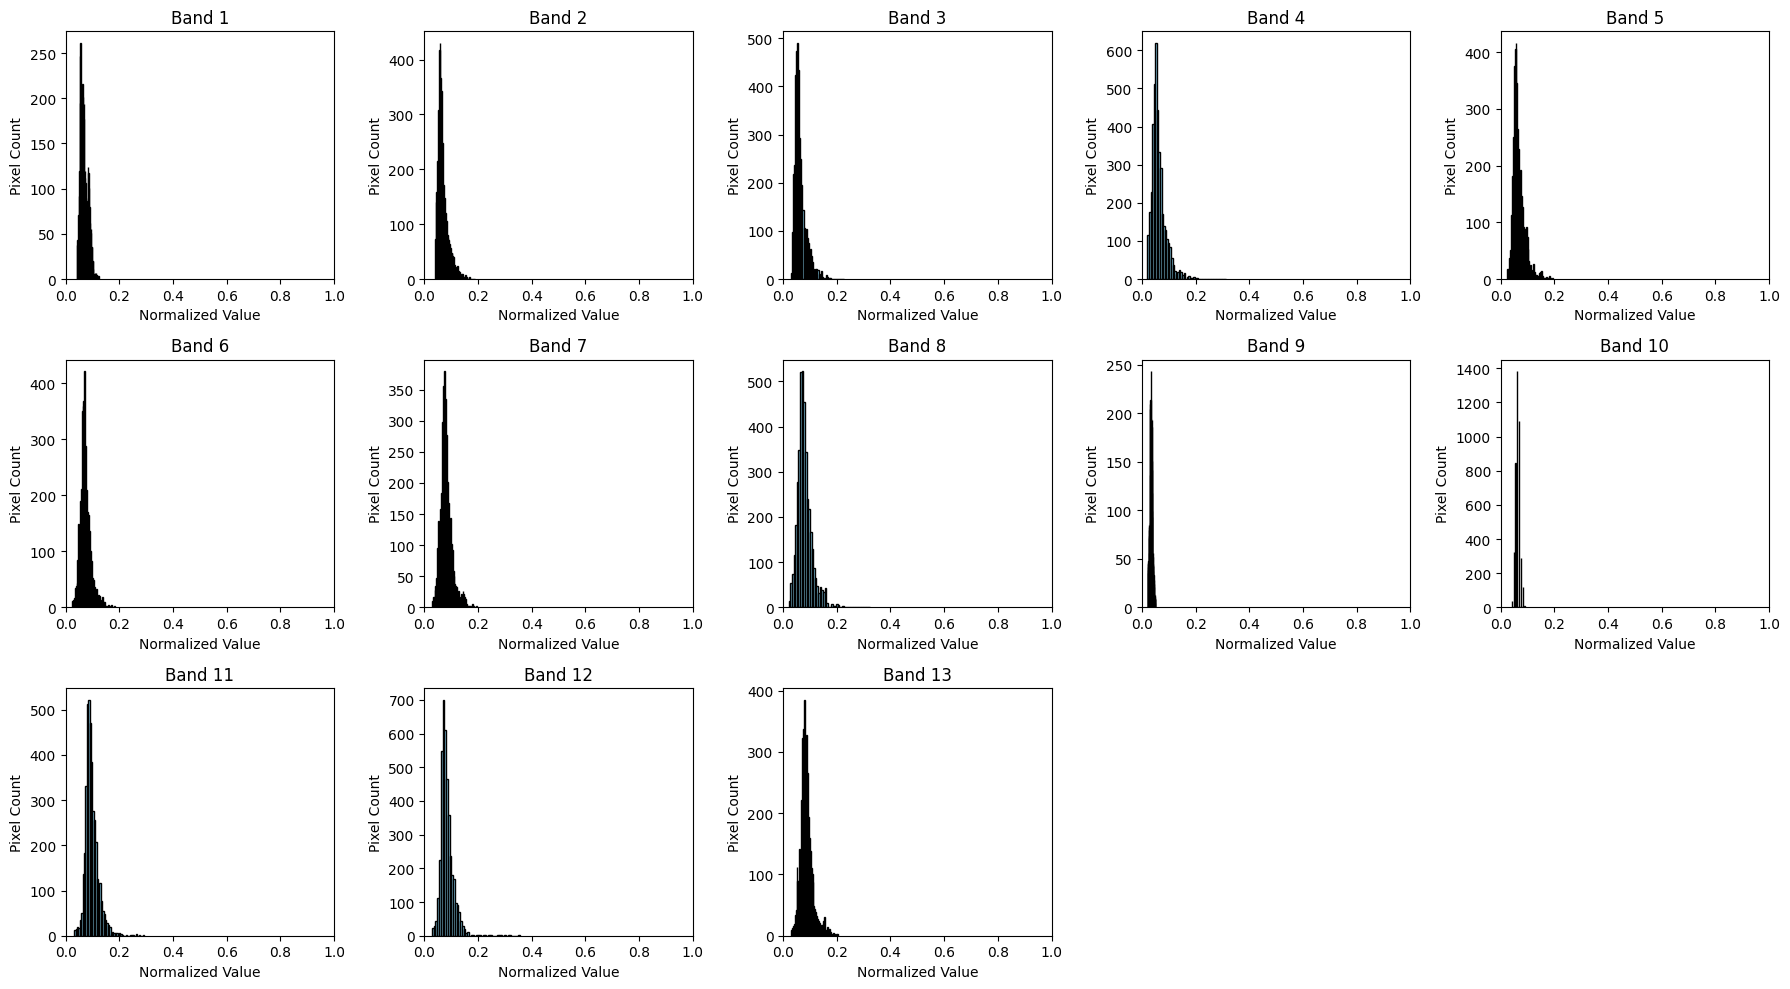

In [ ]:
# Plotting histograms - original image

sample_msi = train_df_proxy_norm.iloc[6002]

print("\nOriginal image: -------------------------------------------------------\n")

fig, axes = plt.subplots(3, 5, figsize = (18, 10))
axes = axes.flatten()

img = normalize(sample_msi['image_arrays'])

for i in range(13):
    band_data = img[i].flatten()
    axes[i].hist(band_data, bins=50, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Band {i+1}')
    axes[i].set_xlim(0, 1)
    axes[i].set_xlabel('Normalized Value')
    axes[i].set_ylabel('Pixel Count')

# Hide any extra subplots
for j in range(13, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("\nNormalized image: -----------------------------------------------------\n")

fig, axes = plt.subplots(3, 5, figsize=(18, 10))
axes = axes.flatten()

for i in range(13):
    band_data = sample_msi['image_norm'][i].flatten()
    axes[i].hist(band_data, bins=50, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Band {i+1}')
    axes[i].set_xlim(0, 1)
    axes[i].set_xlabel('Normalized Value')
    axes[i].set_ylabel('Pixel Count')

# Hide any extra subplots
for j in range(13, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### $\bullet$ Normalize per-channel per-label over dataset (mean/std) NOT USABLE FOR VAL/TEST

In [21]:
import warnings
warnings.filterwarnings("ignore")

sample_tif_path = "/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/River/River_650.tif"

src = rasterio.open(sample_tif_path)

print('Source type: ', type(src))
print("Metadata keys:")
print(src.meta)
img = src.read()  # shape: (13, H, W)
print(f"Image type: {type(img)}")
print(f"Image shape: {img.shape}")  # Should be (13, H, W)
print(f"Image data type: {img.dtype}")
print("Location metadata:")
print(f"- CRS: {src.crs}")
print(f"- Transform:\n{src.transform}")

Source type:  <class 'rasterio.io.DatasetReader'>
Metadata keys:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 64, 'height': 64, 'count': 13, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]]'), 'transform': Affine(10.00255781559539, 0.0, 320134.7934680959,
       0.0, -9.994221518072019, 5509823.11151)}
Image type: <class 'numpy.ndarray'>
Image shape: (13, 64, 64)
Image data type: uint16
Location metadata:
- C

In [22]:
src.stats()

[Statistics(min=1068.0, max=1347.0, mean=1205.795654296875, std=50.681589616316685),
 Statistics(min=772.0, max=2430.0, mean=979.597900390625, std=150.25009484672884),
 Statistics(min=573.0, max=2457.0, mean=901.516845703125, std=177.27044798256995),
 Statistics(min=373.0, max=2172.0, mean=744.515625, std=268.13363504087727),
 Statistics(min=396.0, max=1712.0, mean=1008.906494140625, std=304.01823659195577),
 Statistics(min=411.0, max=3226.0, mean=1703.18017578125, std=655.6468558362328),
 Statistics(min=417.0, max=3896.0, mean=1950.419921875, std=789.0425878883575),
 Statistics(min=310.0, max=4245.0, mean=1913.48388671875, std=932.2646013068056),
 Statistics(min=220.0, max=1356.0, mean=793.655517578125, std=262.46209405223243),
 Statistics(min=6.0, max=77.0, mean=11.6103515625, std=4.052515407299991),
 Statistics(min=183.0, max=2812.0, mean=1403.746826171875, std=609.746220354827),
 Statistics(min=132.0, max=1952.0, mean=935.739501953125, std=426.15765158682996),
 Statistics(min=372.0

In [23]:
src.stats()[0].mean

1205.7956542969

In [24]:
src.statistics(1) # statistics is deprecated, also indexed by 1

Statistics(min=1068.0, max=1347.0, mean=1205.7956542969, std=50.681589616317)

In [18]:
src_1 = rasterio.open("/content/drive/MyDrive/Thesis CLIP4EO/EuroSAT MSI data/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Industrial/Industrial_1581.tif")
src_1.stats()

[Statistics(min=1393.0, max=2469.0, mean=1732.6494140625, std=195.7895228191499),
 Statistics(min=874.0, max=4194.0, mean=1520.30078125, std=454.88102932440853),
 Statistics(min=628.0, max=5097.0, mean=1410.5634765625, std=504.8840690859831),
 Statistics(min=458.0, max=7034.0, mean=1393.67822265625, std=611.3498152896209),
 Statistics(min=646.0, max=3918.0, mean=1447.521484375, std=434.4865195506463),
 Statistics(min=708.0, max=4220.0, mean=1762.32666015625, std=447.7551284037876),
 Statistics(min=750.0, max=4490.0, mean=1912.545166015625, std=499.13324082919587),
 Statistics(min=461.0, max=7268.0, mean=1777.044189453125, std=632.2372912380745),
 Statistics(min=306.0, max=658.0, mean=453.00390625, std=64.51038543127153),
 Statistics(min=7.0, max=14.0, mean=10.113037109375, std=1.1963755299984802),
 Statistics(min=642.0, max=5794.0, mean=1911.9248046875, std=487.28035537695337),
 Statistics(min=485.0, max=6127.0, mean=1428.97119140625, std=432.37446149294584),
 Statistics(min=736.0, max

In [20]:
src_1.stats()[0].mean

1732.6494140625

In [37]:
src_1.statistics(1).mean

1732.6494140625

In [42]:
for i in range(1, len(src_1.stats())+1):
  print(src_1.statistics(i).mean)

1732.6494140625
1520.30078125
1410.5634765625
1393.6782226562
1447.521484375
1762.3266601562
1912.5451660156
1777.0441894531
453.00390625
10.113037109375
1911.9248046875
1428.9711914062
2008.619140625


In [27]:
img.shape # [C, H, W] C are the spectral bands

(13, 64, 64)

In [41]:
test_df.label.value_counts()

,count
label,
Pasture,500
Sea or Lake,500
River,500
Annual Crop,500
Residential Buildings,500
Permanent Crop,500
Industrial Buildings,500
Highway,500
Herbaceous Vegetation,500


In [37]:
from collections import defaultdict

n_bands = img.shape[0]
class_band_means = defaultdict(lambda: [[] for _ in range(n_bands)])
class_band_stds = defaultdict(lambda: [[] for _ in range(n_bands)])

In [39]:
class_band_stds

defaultdict(<function __main__.<lambda>()>, {})

In [ ]:
for idx, row in (test_df.head(600)).iterrows():
    label = row["label"]
    img_path = row["filename"]

    try:
        with rasterio.open(img_path) as src:
            for i in range(n_bands):
                stats = src.stats()[i]
                class_band_means[label][i].append(stats.mean)
                class_band_stds[label][i].append(stats.std)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

class_band_means

'''
class_band_means and class_band_stds look like this:
{
  'Pasture': [[500 means for band 0], [500 means for band 1], [500 means for bands 2], etc.], # 13 lists, 500 values each
  'Sea or Lake': , [[500 means for band 0], [500 means for band 1], [500 means for bands 2], etc.], # 13 lists, 500 values each
  ...
}
'''

In [50]:
# Compute average mean/std per class and band
band_stats_per_class = {}
for label in class_band_means:
    band_means = [np.mean(band_list) for band_list in class_band_means[label]] # list of means for 13 classes
    band_stds = [np.mean(band_list) for band_list in class_band_stds[label]] # list of stds for 13 classes
    band_stats_per_class[label] = {"mean": band_means, "std": band_stds}

'''
band_stats_per_class looks like this:
{
  'Pasture': {
    'mean': [mean_band_0, mean_band_1, ...], # 13 means
    'std': [std_band_0, std_band_1, ...] # 13 stds
  },
  'Sea or Lake': {
    'mean': [mean_band_0, mean_band_1, ...], # 13 means
    'std': [std_band_0, std_band_1, ...] # 13 stds
  },
  ...
}
'''

In [55]:
img

array([[[1339, 1339, 1344, ..., 1255, 1259, 1262],
        [1339, 1339, 1344, ..., 1255, 1259, 1262],
        [1332, 1332, 1337, ..., 1259, 1262, 1264],
        ...,
        [1267, 1267, 1262, ..., 1069, 1069, 1069],
        [1269, 1269, 1261, ..., 1069, 1069, 1069],
        [1269, 1269, 1260, ..., 1069, 1069, 1068]],

       [[ 977,  977,  991, ..., 1083, 1097, 1071],
        [ 977,  977,  991, ..., 1083, 1097, 1071],
        [ 850,  850,  914, ..., 1095, 1105, 1084],
        ...,
        [1070, 1070, 1089, ...,  799,  813,  805],
        [1157, 1157, 1113, ...,  783,  822,  807],
        [1079, 1079, 1091, ...,  794,  802,  788]],

       [[ 917,  917,  892, ..., 1121, 1097, 1069],
        [ 917,  917,  892, ..., 1121, 1097, 1069],
        [1044, 1044,  911, ..., 1090, 1068, 1053],
        ...,
        [ 941,  941, 1043, ...,  755,  734,  703],
        [1064, 1064, 1014, ...,  677,  712,  710],
        [ 958,  958,  909, ...,  707,  712,  700]],

       ...,

       [[1722, 1722, 172

In [ ]:
from collections import defaultdict

def compute_eurosat_band_stats(df, n_bands=13):
    # Dict[class][band] = list of means/stds
    class_band_means = defaultdict(lambda: [[] for _ in range(n_bands)])
    class_band_stds = defaultdict(lambda: [[] for _ in range(n_bands)])

    for idx, row in df.iterrows():
        label = row["label"]
        img_path = row["filename"]

        try:
            with rasterio.open(img_path) as src:
                for i in range(n_bands):
                    stats = src.statistics(i + 1)  # 1-based indexing
                    class_band_means[label][i].append(stats.mean)
                    class_band_stds[label][i].append(stats.std)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    '''
    class_band_means and class_band_stds look like this:
    {
      'Pasture': [[500 means for band 0], [500 means for band 1], [500 means for bands 2], etc.], # 13 lists, 500 values each
      'Sea or Lake': , [[500 means for band 0], [500 means for band 1], [500 means for bands 2], etc.], # 13 lists, 500 values each
      ...
    }
    '''

    # Compute average mean/std per class and band
    band_stats_per_class = {}
    for label in class_band_means:
        band_means = [np.mean(band_list) for band_list in class_band_means[label]]
        band_stds = [np.mean(band_list) for band_list in class_band_stds[label]]
        band_stats_per_class[label] = {"mean": band_means, "std": band_stds}

    '''
    band_stats_per_class looks like this:
    {
      'Pasture': {
        'mean': [mean_band_0, mean_band_1, ...], # 13 means
        'std': [std_band_0, std_band_1, ...] # 13 stds
      },
      'Sea or Lake': {
        'mean': [mean_band_0, mean_band_1, ...], # 13 means
        'std': [std_band_0, std_band_1, ...] # 13 stds
      },
      ...
    }
    '''

    return band_stats_per_class


In [ ]:
class EuroSATMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, class_band_stats):
        self.df = dataframe.reset_index(drop=True) # ensure input df has continuous index
        self.label2idx = label2idx # mapping between string labels and associated integers
        self.class_band_stats = class_band_stats

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label_str = self.df.loc[idx, "label"]
        label = self.label2idx[label_str]

        with rasterio.open(img_path) as src:
            img = src.read()  # shape: [C, H, W] == [13, 64, 64]

        # Per-band normalization based on specific class stats
        means = self.class_band_stats[label_str]["mean"]
        stds = self.class_band_stats[label_str]["std"]

        for c in range(img.shape[0]):
            img[c] = (img[c] - means[c]) / (stds[c] + 1e-6)

        img = torch.tensor(img, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label

But at validation and test time, we don't know the label, so this is unusable...

In [56]:
# Global per-channel normalization
def compute_eu_band_stats(df, n_bands=13):
    band_means = [[] for _ in range(n_bands)]
    band_stds = [[] for _ in range(n_bands)]

    for idx, row in df.iterrows():
        img_path = row["filename"]
        try:
            with rasterio.open(img_path) as src:
                for i in range(n_bands):
                    stats = src.stats()[i]
                    band_means[i].append(stats.mean)
                    band_stds[i].append(stats.std)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    global_mean = [np.mean(m) for m in band_means]
    global_std = [np.mean(s) for s in band_stds]
    global_stats = {"mean": global_mean, "std": global_std}

    return global_stats

In [ ]:
class EuroSATMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, global_stats):
        self.df = dataframe.reset_index(drop=True) # ensure input df has continuous index
        self.label2idx = label2idx # mapping between string labels and associated integers
        self.global_stats = global_stats

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label_str = self.df.loc[idx, "label"]
        label = self.label2idx[label_str]

        with rasterio.open(img_path) as src:
            img = src.read()  # shape: [C, H, W] == [13, 64, 64]

        # Per-band normalization based on global stats
        means = self.global_stats["mean"]
        stds = self.global_stats["std"]

        for c in range(img.shape[0]):
            img[c] = (img[c] - means[c]) / (stds[c] + 1e-6)

        img = torch.tensor(img, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label

## MSI bands

Issues using CLIP with MSI bands (more than 3 channels)

- training clip #119 https://github.com/openai/CLIP/issues/119
- CLIP training code #83 https://github.com/openai/CLIP/issues/83
- Multi-channel images get truncated to 3 channels #3160 https://github.com/python-pillow/Pillow/issues/3160
- Add support for high bit depth multichannel images #1888 https://github.com/python-pillow/Pillow/issues/1888

Building blocks for the additional layers:
- PyTorch Conv2D: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

### Embedder 1

A simple linear layer with learnable parameters that maps $n$ spectral bands $\to$ 3 channels. This way, the model can learn the most useful combination of bands for downstream CLIP tasks (in our case, image classification on datasets of interest).

This projection layer can be trained either end-to-end with a frozen CLIP model or you can pretrain it separately using another task (e.g., image reconstruction or classification).

In [ ]:
import torch
import torch.nn as nn

class MSIEmbedder1(nn.Module):
    def __init__(self, in_channels: int):
        super(MSIEmbedder1, self).__init__()
        self.proj = nn.Conv2d(in_channels, out_channels = 3, kernel_size = 1)
        # stride=1, padding=0 by default
        # 1x1 convolution, 1 pixel -> 1 pixel (kernel_size = 1)

    def forward(self, x):
        return self.proj(x)  # x shape: [B, in_channels, H, W]

### Embedder 2

If we want to have more flexibility than a single 1x1 conv, we could use a small CNN or MLP to map the spectral bands to RGB.

In [ ]:
class MSIEmbedder2(nn.Module):
    def __init__(self, in_channels):
        super(MSIEmbedder2, self).__init__()
        self.proj2 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size = 1), # 32, 128 possible other choices
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size = 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.proj2(x)

## Lightning

Use PyTorch Lightning to structure training:

+ `LightningModule` to define the training logic;

+ `LightningDataModule` to load and batch data (create a Dataset class).

Tutorials:

- https://lightning.ai/docs/pytorch/stable/starter/introduction.html brevissimo tutorial
- https://colab.research.google.com/drive/1Mh3YgcXdEUqGcnWU6ph3XukckXPJIFXS?usp=drive_link notebook che va più nel dettaglio
- https://lightning.ai/docs/pytorch/stable/advanced/speed.html training optimizations

In [ ]:
%%capture
# Step 1: install Lightning
!pip install lightning

In [ ]:
# Step 2: define a LightningModule
# (this enables PyTorch nn.Module to play together in complex ways inside the
#  training_step (there is also an optional validation_step and test_step))

import os
from torch import optim, utils, Tensor
from torchvision.transforms import ToTensor
import lightning as L

import torch.nn.functional as F
from torch.optim import Adam

from torch.utils.data import Dataset
import torchvision.transforms as T

In [ ]:
torch.cuda.is_available() # we check if we're using GPUs

False

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
#L.seed_everything(0) # for reproducibility

#### Define the dataset

Notes:

- CLIP, and PyTorch in general, expects images of shape `[C, H, W]`
- $\to$ <u>Normalization</u>: let's start with a simple one, but we could try a per-band calibration instead of the global one, or histogram normalization, could do some research
  - Good blog post about normalization techniques for EO: https://medium.com/sentinel-hub/how-to-normalize-satellite-images-for-deep-learning-d5b668c885af
  - Potential direction for future work


In [ ]:
img.shape

(13, 64, 64)

In [ ]:
normalize(img).shape

(13, 64, 64)

In [ ]:
import rasterio


# Global normalization over all 13 channels
def normalize(array):
    array = array.astype(np.float32)
    return (array - array.min()) / (array.max() - array.min())


class EuroSATMSIDataset(Dataset):
    def __init__(self, dataframe, label2idx, transform=None):
        self.df = dataframe.reset_index(drop=True) # ensure input df has continuous index
        self.transform = transform
        self.label2idx = label2idx # mapping between string labels and associated integers

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label_str = self.df.loc[idx, "label"]
        label = self.label2idx[label_str]

        with rasterio.open(img_path) as src:
            img = src.read()  # shape: [C, H, W] == [13, 64, 64]

        img = normalize(img) # GLOBAL NORMALIZATION -> all pixel values in [0, 1]
        img = torch.tensor(img, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
import os
os.cpu_count()

2

In [ ]:
# Get GPU information
!nvidia-smi

Mon May 12 14:26:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P0             31W /   70W |     470MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from torch.utils.data import DataLoader

class EuroSATDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, label2idx, batch_size=32):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label2idx = label2idx
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = EuroSATMSIDataset(self.train_df, self.label2idx)
        self.val_dataset = EuroSATMSIDataset(self.val_df, self.label2idx)
        self.test_dataset = EuroSATMSIDataset(self.test_df, self.label2idx)

    def train_dataloader(self):
        if device == 'cuda':
            return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True) # optimized
        else:
            return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2) # num_workers=0 default

    def val_dataloader(self):
        if device == 'cuda':
            return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True) # optimized
        else:
            return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers = 2) # num_workers=0 default

    def test_dataloader(self):
        if device == 'cuda':
            return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers = 2, pin_memory=True) # optimized
        else:
            return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers = 2) # num_workers=0 default

 #### Define LightningModule(s)

 - Cross Entropy is de-facto loss function in modern classification tasks

In [ ]:
CLIP_preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7b1f75ff7f60>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [ ]:
CLIP_preprocess.transforms

[Resize(size=224, interpolation=bicubic, max_size=None, antialias=True),
 CenterCrop(size=(224, 224)),
 <function clip.clip._convert_image_to_rgb(image)>,
 ToTensor(),
 Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))]

In [ ]:
CLIP_model

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

$\to$ [CLIP preprocess] To be able to use the output of MSIEmbedder, we need to write our own preprocessing pipeline reusing the transforms of CLIP preprocess. This outputs a tensor, but only accepts PIL images as inputs which is not what we'll feed it.

$\to$ [CLIP image encoder] Since we are removing the preprocess and its restrictions, one might think that it could be possible to feed MSI images to CLIP image encoder directly, but this is not really the case.
  - First of all, CLIP is pre-trained on 3-channels RGB images and expects inputs of that specific shape;
  - The purpose of MSIEmbedder is to learn to translate the multispectral information into RGB-like images that maximize alignment with CLIP's semantic space;
  - Feeding 13-band MSI directly to CLIP would only be possible by retrain CLIP from scratch (what they did in the MS-CLIP paper)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
import clip
from torchvision import transforms as T

device = "cuda" if torch.cuda.is_available() else "cpu"

class CLIPWithMSIEmbedder1(L.LightningModule):
    def __init__(self, in_channels, class_names, learning_rate=5e-3): # 1e-3, 1e-4, 1e-5
        super().__init__()
        self.save_hyperparameters()

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device)
        # _ is because we can't use clip preprocess, as it outputs a tensor
        # but only accepts PIL images as inputs and that's not what MSIEmbedder gives us
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder1(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of {name.lower()}" for name in class_names]
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224)),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = F.cross_entropy(logits, y) # check for loss function balancing
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)



class CLIPWithMSIEmbedder2(L.LightningModule):
    def __init__(self, in_channels, class_names, learning_rate=1e-3): # 1e-4, 1e-5
        super().__init__()
        self.save_hyperparameters()

        # Load CLIP
        self.clip_model, _ = clip.load("ViT-B/32", device=device)
        # _ is because we can't use clip preprocess, as it outputs a tensor
        # but only accepts PIL images as inputs and that's not what MSIEmbedder gives us
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.image_encoder = self.clip_model.encode_image
        self.text_encoder = self.clip_model.encode_text

        # MSI embedder
        self.embedder = MSIEmbedder2(in_channels)

        # Compute text embeddings once for all
        prompts = [f"a satellite photo of {name.lower()}" for name in class_names]
        tokenized = clip.tokenize(prompts)
        with torch.no_grad():
            self.text_features = self.text_encoder(tokenized.to(device)).detach()  # [num_classes, 512]
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            #self.register_buffer("text_features", self.text_features) # good practice for constant tensors (like text_features).

        self.learning_rate = learning_rate

        # Transforms to preprocess images after MSIEmbedder, before CLIP
        self.MSI_to_CLIP_preprocess = T.Compose([
            T.Resize((224, 224)),
            T.Normalize((0.48145466, 0.4578275, 0.40821073),
                        (0.26862954, 0.26130258, 0.27577711))
        ])

    def forward(self, x):
        x = self.embedder(x)  # [B, 3, 64, 64]
        x = self.MSI_to_CLIP_preprocess(x)
        image_features = self.image_encoder(x)  # [B, 512]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features  # just return the features, compute similarity later

    def predict_logits(self, x):
        image_features = self(x)  # [B, 512]
        logits = 100.0 * image_features @ self.text_features.T  # [B, num_classes]
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.predict_logits(x)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.embedder.parameters(), lr=self.learning_rate)

### Train Model 1

The goal would be to reach at least the original CLIP's performance on the RGB images: $38.76\%$

In [ ]:
import os
import torch
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import torch._dynamo
torch._dynamo.config.suppress_errors = True


# 1. Encode string labels into integers
le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())

# 2. Load data module
data_module = EuroSATDataModule(train_df, val_df, test_df, label2idx, batch_size = 32) # batch_size = 8, 16, 32, 64(not sure)

# 3. Create the model
model = CLIPWithMSIEmbedder1(
    in_channels = 13,
    class_names = class_names,
    learning_rate = 1e-3,
)

# 3.1 Compile the model - can result in significant speedups
model = torch.compile(model)

# 4. Specify a checkpoint callback
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    dirpath="/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/",
    filename="clip-msi1-{epoch:02d}-{val_acc:.4f}", # not a format string, values will be filled at runtime
    save_top_k=1, # save only the checkpoint with the highest performance (here, val_acc)
    monitor="val_acc",
    mode="max"
)

# Note:
# - save_top_k=3 would keep the top 3 best-performing checkpoints
# - save_top_k=-1 saves every epoch's checkpoint
# - save_top_k=0 disables saving entirely

# # 5. Specify logger in csv format
logger = CSVLogger(save_dir="/content/drive/MyDrive/Thesis CLIP4EO/logs/", name="clip-msi1")

# define the logger object
logger_tb = TensorBoardLogger("/content/drive/MyDrive/Thesis CLIP4EO/tb_logs/", name = "net", log_graph = True)

# 6. Trainer
trainer = L.Trainer(
    max_epochs=10,
    accelerator="auto",
    devices=1,
    #precision="16-mixed", # enable AMP (Automatic Mixed Precision) # -> error after first epoch
    log_every_n_steps=5,
    callbacks=[checkpoint_callback],
    logger=logger # csv logger (can I pass more than one?)
)

# 7. Training
print("\nStarting training...\n")
trainer.fit(model, datamodule=data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



Starting training...



/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/.shortcut-targets-by-id/1A8eLV_sv77qQ7RM5Lh2nkgzNupdYOO2Q/Thesis CLIP4EO/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | clip_model | CLIP         | 151 M  | eval 
1 | embedder   | MSIEmbedder1 | 42     | train
----------------------------------------------------
42        Trainable params
151 M     Non-trainable params
151 M     Total params
605.109   Total estimated model params size (MB)
2         Modules in train mode
227       Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | clip_model | CLIP         | 151

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

W0508 15:30:56.842000 191 torch/_inductor/utils.py:1137] [2/0_1] Not enough SMs to use max_autotune_gemm mode


Training: |          | 0/? [00:00<?, ?it/s]

E0508 16:49:33.687000 191 torch/_subclasses/fake_tensor.py:2388] [4/2] failed while attempting to run meta for aten._upsample_bilinear2d_aa_backward.default
E0508 16:49:33.687000 191 torch/_subclasses/fake_tensor.py:2388] [4/2] Traceback (most recent call last):
E0508 16:49:33.687000 191 torch/_subclasses/fake_tensor.py:2388] [4/2]   File "/usr/local/lib/python3.11/dist-packages/torch/_subclasses/fake_tensor.py", line 2384, in _dispatch_impl
E0508 16:49:33.687000 191 torch/_subclasses/fake_tensor.py:2388] [4/2]     r = func(*args, **kwargs)
E0508 16:49:33.687000 191 torch/_subclasses/fake_tensor.py:2388] [4/2]         ^^^^^^^^^^^^^^^^^^^^^
E0508 16:49:33.687000 191 torch/_subclasses/fake_tensor.py:2388] [4/2]   File "/usr/local/lib/python3.11/dist-packages/torch/_ops.py", line 723, in __call__
E0508 16:49:33.687000 191 torch/_subclasses/fake_tensor.py:2388] [4/2]     return self._op(*args, **kwargs)
E0508 16:49:33.687000 191 torch/_subclasses/fake_tensor.py:2388] [4/2]            ^^^^^

Validation: |          | 0/? [00:00<?, ?it/s]

W0508 16:50:26.595000 191 torch/_dynamo/convert_frame.py:906] [13/8] torch._dynamo hit config.cache_size_limit (8)
W0508 16:50:26.595000 191 torch/_dynamo/convert_frame.py:906] [13/8]    function: 'log' (/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/module.py:376)
W0508 16:50:26.595000 191 torch/_dynamo/convert_frame.py:906] [13/8]    last reason: 13/0: ___check_obj_id(L['self']._trainer._logger_connector._current_fx, 9691392)
W0508 16:50:26.595000 191 torch/_dynamo/convert_frame.py:906] [13/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0508 16:50:26.595000 191 torch/_dynamo/convert_frame.py:906] [13/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


---
- Validation and test on third model (10 epochs):

In [ ]:
import os
import torch
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# 1. Encode string labels into integers
le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())

# 2. Load data module
data_module = EuroSATDataModule(train_df, val_df, test_df, label2idx, batch_size = 32)

# Load checkpoint path
checkpoint_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi1-epoch=05-val_acc=0.2474.ckpt"

# Load the model from checkpoint
model = CLIPWithMSIEmbedder1.load_from_checkpoint(
    checkpoint_path,
    in_channels=13,
    class_names=class_names,
    learning_rate=1e-3
)

In [ ]:
trainer = Trainer(accelerator = "auto", devices = 1)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.validate(model, datamodule=data_module)

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.24660000205039978    │
│         val_loss          │    2.0580554008483887     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 2.0580554008483887, 'val_acc': 0.24660000205039978}]

In [ ]:
trainer.test(model, datamodule=data_module)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.24660000205039978    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.24660000205039978}]

---
- Validation and test on second model (3 epochs):

In [ ]:
trainer.validate(model, datamodule=data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.2937999963760376     │
│         val_loss          │    1.9409890174865723     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.9409890174865723, 'val_acc': 0.2937999963760376}]

In [ ]:
trainer.test(model, datamodule=data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.29100000858306885    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.29100000858306885}]

---

- Validation and test on first model (1 epoch):

In [ ]:
# 8. Validation
print("Running validation...")
val_results = trainer.validate(model, datamodule=data_module)
print("Validation results:", val_results)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running validation...


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.18940000236034393    │
│         val_loss          │     2.096170425415039     │
└───────────────────────────┴───────────────────────────┘

Validation results: [{'val_loss': 2.096170425415039, 'val_acc': 0.18940000236034393}]


In [ ]:
# 9. Test
print("Running test set evaluation...")
test_results = trainer.test(model, datamodule=data_module)
print("Test results:", test_results)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running test set evaluation...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.19580000638961792    │
└───────────────────────────┴───────────────────────────┘

Test results: [{'test_acc': 0.19580000638961792}]


---

In [ ]:
# Resume training of the previously saved checkpoint

# from lightning.pytorch import Trainer
# from lightning.pytorch.callbacks import ModelCheckpoint

# # Load model from checkpoint
# checkpoint_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/"  # to update to ckpt of interest
# model = CLIPWithMSIEmbedder1.load_from_checkpoint(
#     checkpoint_path,
#     in_channels=13,
#     class_names=class_names,
#     learning_rate=1e-3
# )

# trainer = Trainer(max_epochs=10)
# trainer.fit(model, datamodule=data_module)

In [ ]:
model

CLIPWithMSIEmbedder(
  (clip_model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamica

### Train Model 2


In [ ]:
import os
import torch
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import torch._dynamo
torch._dynamo.config.suppress_errors = True


# 1. Encode string labels into integers
le = LabelEncoder()
le.fit(train_df["label"])
label2idx = {label: idx for idx, label in enumerate(le.classes_)}
class_names = list(label2idx.keys())

# 2. Load data module
data_module = EuroSATDataModule(train_df, val_df, test_df, label2idx, batch_size = 32) # batch_size = 8, 16, 32, 64(not sure)

# 3. Create the model
model_2 = CLIPWithMSIEmbedder2(
    in_channels = 13,
    class_names = class_names,
    learning_rate = 1e-3,
)

# 3.1 Compile the model - can result in significant speedups
#model_2 = torch.compile(model_2)  # W0509: not enough SMs to use max_autotune_gemm mode -> doesn't work, turn it off

# 4. Specify a checkpoint callback
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    dirpath="/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/",
    filename="clip-msi2-{epoch:02d}-{val_acc:.4f}", # not a format string, values will be filled at runtime
    save_top_k=1, # save only the checkpoint with the highest performance (here, val_acc)
    monitor="val_acc",
    mode="max"
)

# Note:
# - save_top_k=3 would keep the top 3 best-performing checkpoints
# - save_top_k=-1 saves every epoch's checkpoint
# - save_top_k=0 disables saving entirely

# # 5. Specify logger in csv format
logger = CSVLogger(save_dir="/content/drive/MyDrive/Thesis CLIP4EO/logs/", name="clip-msi2")

# define the logger object
logger_tb = TensorBoardLogger("/content/drive/MyDrive/Thesis CLIP4EO/tb_logs/", name="clip-msi2", log_graph=True)

# 6. Trainer
trainer = L.Trainer(
    max_epochs=1,
    accelerator="auto",
    devices=1,
    #precision="16-mixed", # enable AMP (Automatic Mixed Precision) # -> error after first epoch
    log_every_n_steps=5,
    callbacks=[checkpoint_callback],
    logger=logger
)

# 7. Training
print("\nStarting training...\n")
trainer.fit(model_2, datamodule=data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



Starting training...



/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/.shortcut-targets-by-id/1A8eLV_sv77qQ7RM5Lh2nkgzNupdYOO2Q/Thesis CLIP4EO/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | clip_model | CLIP         | 151 M  | eval 
1 | embedder   | MSIEmbedder2 | 1.1 K  | train
----------------------------------------------------
1.1 K     Trainable params
151 M     Non-trainable params
151 M     Total params
605.114   Total estimated model params size (MB)
6         Modules in train mode
227       Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | clip_model | CLIP         | 151

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


---
- Validation and test of the model ($1$ epoch):

In [ ]:
trainer.validate(model_2, datamodule=data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.28999999165534973    │
│         val_loss          │    1.9140655994415283     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.9140655994415283, 'val_acc': 0.28999999165534973}]

In [ ]:
trainer.test(model_2, datamodule=data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.296999990940094     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.296999990940094}]

---
- Validation and test of the model ($3$ epochs):

In [ ]:
# 6. Trainer
trainer = L.Trainer(
    max_epochs=2,
    accelerator="auto",
    devices=1,
    log_every_n_steps=5,
    callbacks=[checkpoint_callback],
    logger=logger
)

# 7. Resume training from above
print("\nRe-starting training...\n")
trainer.fit(model_2, datamodule=data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | clip_model | CLIP         | 151 M  | eval 
1 | embedder   | MSIEmbedder2 | 1.1 K  | train
----------------------------------------------------
1.1 K     Trainable params
151 M     Non-trainable params
151 M     Total params
605.114   Total estimated model params size (MB)
6         Modules in train mode
227       Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | clip_model | CLIP        


Re-starting training...



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
trainer.validate(model_2, datamodule=data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.3393999934196472     │
│         val_loss          │    1.8265398740768433     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.8265398740768433, 'val_acc': 0.3393999934196472}]

In [ ]:
trainer.test(model_2, datamodule=data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.33480000495910645    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.33480000495910645}]

---
- Validation and test of the model ($5$ epochs):

In [ ]:
# 6. Trainer
trainer = L.Trainer(
    max_epochs=2,
    accelerator="auto",
    devices=1,
    log_every_n_steps=5,
    callbacks=[checkpoint_callback],
    logger=logger
)

# 7. Resume training from above
print("\nRe-starting training...\n")
trainer.fit(model_2, datamodule=data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | clip_model | CLIP         | 151 M  | eval 
1 | embedder   | MSIEmbedder2 | 1.1 K  | train
----------------------------------------------------
1.1 K     Trainable params
151 M     Non-trainable params
151 M     Total params
605.114   Total estimated model params size (MB)
6         Modules in train mode
227       Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | clip_model | CLIP        


Re-starting training...



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
trainer.validate(model_2, datamodule=data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.36000001430511475    │
│         val_loss          │     1.758646845817566     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.758646845817566, 'val_acc': 0.36000001430511475}]

In [ ]:
trainer.test(model_2, datamodule=data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.36160001158714294    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.36160001158714294}]

### Tensorboard

In [ ]:
#%load_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Thesis CLIP4EO/logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2025-05-07 14:09:33.557279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746626973.577947   55845 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746626973.583990   55845 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 14:09:33.605715: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
usage: tensorboard [-h] [--helpfull] [--logd

### Visualize learned image embedding

In [ ]:
# Load model from checkpoint

from lightning.pytorch.callbacks import ModelCheckpoint

model_msi1 = CLIPWithMSIEmbedder1.load_from_checkpoint(
    "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi1-epoch=03-val_acc=0.3068.ckpt",
    in_channels=13,
    class_names=class_names,
    learning_rate=1e-3
)

model_msi2 = CLIPWithMSIEmbedder2.load_from_checkpoint(
    "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi2-epoch=01-val_acc=0.3394.ckpt",
    in_channels=13,
    class_names=class_names,
    learning_rate=1e-3
)

In [ ]:
# Visualize learned "RGB" outputs

input_msi_image = ...
img_embedded = model.embedder(input_msi_image.unsqueeze(0))  # 1 example
img_embedded = img_embedded.squeeze().permute(1, 2, 0).cpu().numpy()
plt.imshow(img_embedded)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Thesis CLIP4EO/checkpoints/clip-msi-epoch=03-val_acc=0.3068.ckpt"

# Load the model from checkpoint
model_from_ckpt = CLIPWithMSIEmbedder1.load_from_checkpoint(checkpoint_path)

# Set to evaluation mode
model_from_ckpt.eval()
model_from_ckpt.freeze()
model_from_ckpt.to(device)

In [ ]:
def normalize(array):
    array = array.astype(np.float32)
    return (array - array.min()) / (array.max() - array.min())


sample_image = test_df.iloc[1005]
sample_image_label = sample_image.label

with rasterio.open(sample_image.filename) as src:
    sample_img = src.read()
rgb = np.stack([sample_img[3], sample_img[2], sample_img[1]])
rgb_norm = normalize(rgb)
sample_img = sample_img.to(device)

# Pass through MSIEmbedder only
with torch.no_grad():
    learned_rgb = model.embedder(sample_img)[0]  # shape [3, H, W]

NameError: name 'img' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_side_by_side(true_rgb_np, learned_rgb_tensor, title1="True RGB", title2="Learned RGB"):
    # Ensure learned_rgb_tensor is on CPU and convert to numpy
    learned_rgb_np = learned_rgb_tensor.detach().cpu().numpy()

    # Normalize learned RGB for visualization
    learned_rgb_np = (learned_rgb_np - learned_rgb_np.min()) / (learned_rgb_np.max() - learned_rgb_np.min())

    # Transpose from [C, H, W] to [H, W, C]
    learned_rgb_np = np.transpose(learned_rgb_np, (1, 2, 0))

    # Clip both to [0, 1] just to be safe
    true_rgb_np = np.clip(true_rgb_np, 0, 1)
    learned_rgb_np = np.clip(learned_rgb_np, 0, 1)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(true_rgb_np)
    axs[0].set_title(title1)
    axs[0].axis("off")

    axs[1].imshow(learned_rgb_np)
    axs[1].set_title(title2)
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function with your manually loaded image
show_side_by_side(rgb_norm.transpose(1, 2, 0), learned_rgb)

### Using the model for inference

In [ ]:
# Using the model for inference on a single image

from torchvision import transforms
import torch

# Example image tensor: assume it's a (13, H, W) MSI image
# Replace this with actual loading code
image = your_msi_image_tensor  # shape: [13, H, W], type: torch.Tensor

# Add batch dimension
image = image.unsqueeze(0)  # shape becomes [1, 13, H, W]
image = image.to(model.device)

In [ ]:
# Using the model for inference on test dataset

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
# Put model in eval mode and on correct device
model.eval()
model.to(device)

all_preds = []
all_targets = []

# Get test dataloader
test_loader = data_module.test_dataloader()

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(model.device)
        logits = model.predict_logits(x)
        preds = logits.argmax(dim=1).cpu()
        all_preds.extend(preds.tolist())
        all_targets.extend(y.tolist())


In [ ]:
# BONUS saving to csv
pred_df = pd.DataFrame({
    "predicted": all_preds,
    "actual": all_targets
})
pred_df.to_csv("clip_test_predictions.csv", index=False)

## LoRA + PyTorch (?)

- IBM What is LoRA https://www.ibm.com/think/topics/parameter-efficient-fine-tuning
- (redirect alla home page, forse bisogna registrarsi) https://lightning.ai/docs/overview/finetune-models/llm-low-rank-adaption-of-large-language-models-lora